<a href="https://colab.research.google.com/github/ntshrocha/MAB605-2019.1/blob/master/Avalia%C3%A7%C3%A3o_de_Recupera%C3%A7%C3%A3o_Natasha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Código dos exercícios anteriores

In [0]:
import re # expressões regulares
import functools # programação funcional
import numpy as np
import pandas as pd
import operator

# UTILS ########################################################################

def tokenize(string, separators, stopwords):
  regex = re.compile(f'[{"".join(separators)}]+')
  tokens = re.split(regex, string) # split on separators
  tokens = [x.lower() for x in tokens] # lowercase token
  tokens = filter(lambda x: x not in stopwords, tokens) # remove stopwords
  return list(filter(None, tokens)) # remove empty tokens

def tokenizer(documents, separators, stopwords):
  return [tokenize(doc, separators, stopwords) for doc in documents]

def incidence_matrix(tokenized_docs, alphabet = None):
  # Transforma array de arrays em um único array:
  flatten = lambda l: [item for sublist in l for item in sublist]

  if alphabet is None:
    # Filtra palavras únicas e retorna alfabeto com todas as palavras nos docs:
    alphabet = functools.reduce(lambda l, x: l if x in l else l+[x], flatten(tokenized_docs), [])

  IM = pd.DataFrame(columns=alphabet)
  # Para cada documento:
  for i, doc in enumerate(tokenized_docs):
    doc_name = f'{i+1}'
    # Cria linha para adicionar no dataframe
    row = pd.Series(np.zeros(len(alphabet)), index=alphabet, name=doc_name, dtype=int)
    # Para cada palavra do documento:
    for word in doc:
      row[word] += 1
    IM = IM.append(row)
  return IM

def sort(rank):
  return sorted(rank.items(), key=lambda kv: -kv[1])

In [0]:
# MODELO VETORIAL ##############################################################

def get_tf(matrix):
  TF = matrix.copy().applymap(lambda f: 0 if f == 0 else 1 + np.log2(f))
  return TF

def get_idf(matrix):
  N = matrix.shape[0] # Número total de documentos
  IDF = matrix.astype(bool).sum() # Conta valores não nulos por coluna
  return IDF.apply(lambda n: np.log2(N/n))

def get_tf_idf(TF, IDF):
  TF = TF.where(TF != 0) # Zeros transformados em NaN para não atrapalhar contas
  w = TF.mul(IDF)
  return w.fillna(0) # Transforma NaN de volta em 0

def vetorial(docs, stopwords, query, seps):
  # Pré-processamento dos docs e query:
  tokens_query = tokenize(query, seps, stopwords)
  tokens_docs = tokenizer(docs, seps, stopwords)

  # Criação da matriz de incidência com frequência:
  IM_docs = incidence_matrix(tokens_docs)
  IM_query = incidence_matrix([tokens_query], alphabet = IM_docs.columns)
  
  # Frequência total de ocorrência dos termos:
  TF = get_tf(IM_docs)
  TF_query = get_tf(IM_query)
  
  # Frequência de documento:
  IDF = get_idf(IM_docs)
  
  # Ponderação TF-IDF:
  w = get_tf_idf(TF, IDF)
  w_query = get_tf_idf(TF_query, IDF)
  
  rank = {}
  
  def sim(w1, w2):
    return w1.dot(w2)/(np.linalg.norm(w1)*np.linalg.norm(w2))
  
  for name, vector in w.iterrows():
    rank[name] = sim(vector, w_query.T)[0]
  
  return sort(rank)

In [0]:
# MODELO PROBABILÍSTICO ########################################################

def avg_doclen(docs):
  N = len(docs) # número total de documentos
  return functools.reduce(lambda avg_len, doc: avg_len + len(doc)/N, docs, 0)

def BM25(docs, stopwords, query, seps, K1=1, b=0.75):
  # Pré-processamento dos docs e query:
  tokens_query = tokenize(query, seps, stopwords)
  tokens_docs = tokenizer(docs, seps, stopwords)

  # Criação da matriz de incidência com frequência:
  IM_docs = incidence_matrix(tokens_docs)
  IM_query = incidence_matrix([tokens_query], alphabet = IM_docs.columns)
  
  # Dados sobre documentos
  avg_len = avg_doclen(tokens_docs)
  N = len(docs)
  n = IM_docs.astype(bool).sum() # Conta a quantidade de valores não nulos por coluna
  
  # Construção do Beta
  B = (K1 + 1)*IM_docs
  
  for i, doc in enumerate(tokens_docs):
    divisor = K1 * (1 - b + b*(len(doc)/avg_len)) + IM_docs.iloc[i]
    B.iloc[i] = B.iloc[i]/divisor
  
  rank = {}
  
  for name, row in B.iterrows():
    rank[name] = 0
    sim = row * np.log((N - n + 0.5)/(n + 0.5))
    for word in tokens_query:
      rank[name] += sim[word]
  
  return sort(rank)

## Exercício 7 - Avaliação de Recuperação de Informação

In [0]:
# DADOS DO PROBLEMA ############################################################

documentos = ['O peã e o caval são pec de xadrez. O caval é o melhor do jog.', 'A jog envolv a torr, o peã e o rei.', 'O peã lac o boi', 'Caval de rodei!', 'Polic o jog no xadrez.']

stopwords = ['a', 'o', 'e', 'é', 'de', 'do', 'no', 'são']

consulta = 'xadrez peã caval torr'

separadores = [' ',',','.','!','?']

R = [1, 2] # identificador dos documentos relevantes para a consulta q

In [0]:
# RESULTADOS OBTIDOS ###########################################################

resultado_vetorial = vetorial(documentos, stopwords, consulta, separadores)
resultado_bm25 = BM25(documentos, stopwords, consulta, separadores)

print(resultado_vetorial)
print(resultado_bm25)

[('2', 0.4651729931620071), ('1', 0.415053375730601), ('4', 0.21298960013595078), ('5', 0.20532236528436032), ('3', 0.052555274134206874)]
[('2', 0.6968137618714486), ('4', 0.41411967584149284), ('1', 0.37779338848697586), ('5', 0.37127970937513144), ('3', -0.37127970937513144)]


In [0]:
# REVOCAÇÃO E PRECISÃO, CONSIDERANDO TODOS OS DOCUMENTOS RECUPERADOS ###########

def recall(resultado, relevantes):
  if (type(resultado[0]) == tuple):
    resultado = [int(x[0]) for x in resultado if x[1] >= 0]
  R_recuperados = [x for x in resultado if x in relevantes]
  return len(R_recuperados)/len(relevantes)

def precision(resultado, relevantes):
  if (type(resultado[0]) == tuple):
    resultado = [int(x[0]) for x in resultado if x[1] >= 0]
  R_recuperados = [x for x in resultado if x in relevantes]
  return len(R_recuperados)/len(resultado)

print("\033[1mModelo Vetorial:\033[0m")
print(f'Revocação: {recall(resultado_vetorial, R)}')
print(f'Precisão: {precision(resultado_vetorial, R)}\n')

print("\033[1mBM25:\033[0m")
print(f'Revocação: {recall(resultado_bm25, R)}')
print(f'Precisão: {precision(resultado_bm25, R)}')

Modelo Vetorial:
Revocação: 1.0
Precisão: 0.4

BM25:
Revocação: 1.0
Precisão: 0.5


In [0]:
# REVOCAÇÃO E PRECISÃO A CADA RELEVANTE RECUPERADO #############################

def make_recall_vs_precision_table(resultado, relevantes):
  resultado = [int(x[0]) for x in resultado if x[1] >= 0]
  table = []
  m = 0
  for doc in resultado:
    if doc in relevantes:
      rank = resultado.index(doc)
      m += 1
      table.append(recall(resultado[:rank+1], relevantes))
      table.append(precision(resultado[:rank+1], relevantes))
  
  table = np.reshape(table, (m,2))
  
  return pd.DataFrame(table, columns=["Revocação", "Precisão"])

table_vetorial = make_recall_vs_precision_table(resultado_vetorial, R)
table_bm25 = make_recall_vs_precision_table(resultado_bm25, R)

print("\033[1mModelo Vetorial:\033[0m")
print(table_vetorial.to_string(index=False))

print("\n\033[1mBM25:\033[0m")
print(table_bm25.to_string(index=False))

Modelo Vetorial:
 Revocação  Precisão
       0.5       1.0
       1.0       1.0

BM25:
 Revocação  Precisão
       0.5  1.000000
       1.0  0.666667


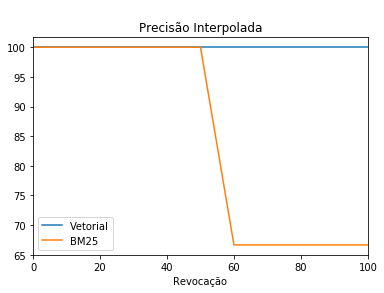

In [0]:
# PRECISÃO INTERPOLADA PARA CADA UM DOS 11 NÍVEIS PADRÃO DE REVOCAÇÃO ##########

def precisao_interpolada(resultado, relevantes):
  table1 = make_recall_vs_precision_table(resultado, relevantes)
  
  table2 = pd.DataFrame([[i*0.1, 0] for i in range(0,11)], columns=['Revocação', 'Precisão'])
  
  for nivel in table1.items():
    revocacao = nivel[1][0]
    precisao = nivel[1][1]
    
    # Atualiza todos os menores
    i = 0
    while (i * 0.1) <= revocacao:
      atual = table2.loc[i, 'Precisão']
      if precisao > atual:
        table2.loc[i, 'Precisão'] = precisao
      i += 1
  
  return table2

plt_vetorial = (precisao_interpolada(resultado_vetorial, R) * 100).plot(kind='line', x="Revocação", y="Precisão", label="Vetorial")
(precisao_interpolada(resultado_bm25, R) * 100).plot(kind='line', x="Revocação", y="Precisão", ax=plt_vetorial, label="BM25", title="\nPrecisão Interpolada");

In [0]:
# MEDIDA F1, CONSIDERANDO TODOS OS DOCUMENTOS RECUPERADOS ######################

def F(resultado, relevantes, beta = 1):
  resultado = [int(x[0]) for x in resultado if x[1] >= 0]
  P = []
  r = []
  for doc in resultado:
    rank = resultado.index(doc)
    P.append(recall(resultado[:rank+1], relevantes))
    r.append(precision(resultado[:rank+1], relevantes))
  
  P = np.array(P)
  r = np.array(r)
  
  return ((1 + beta**2) * P * r)/((beta**2 * P) + r)

print("\033[1mModelo Vetorial:\033[0m")
print(f'F1 = {F(resultado_vetorial, R, 1)}')

print("\n\033[1mBM25:\033[0m")
print(f'F1 = {F(resultado_bm25, R, 1)}')

Modelo Vetorial:
F1 = [0.66666667 1.         0.8        0.66666667 0.57142857]

BM25:
F1 = [0.66666667 0.5        0.8        0.66666667]


In [0]:
# PRECISÃO MÉDIA PARA A CONSULTA (MAPi) ########################################

def MAP(resultado, relevantes):
  P = make_recall_vs_precision_table(resultado, relevantes)['Precisão']
  return P.mean()

print("\033[1mModelo Vetorial:\033[0m")
print(f'MAP = {MAP(resultado_vetorial, R)}')

print("\n\033[1mBM25:\033[0m")
print(f'MAP = {MAP(resultado_bm25, R)}')

Modelo Vetorial:
MAP = 1.0

BM25:
MAP = 0.8333333333333333
